In [2]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 이 아래에서부터 모든 셀 gpu로 할당
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [4]:
# import tokenization as tk

In [5]:
import os
import re
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from transformers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split


from keras_bert import get_base_dict, get_model, compile_model, gen_batch_inputs
from tensorflow.keras.models import load_model

from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import AdamWarmup, calc_train_steps
from keras_bert import Tokenizer

from tqdm import tqdm
import gc
import codecs

import collections
import six

# 데이터 불러오기 
- 이상치 삭제

In [6]:
data = np.load('./sttEmotionTrainTest.npz')
X_train=data['X_train']
y_train=data['y_train']
y_test=data['y_test']
X_test=data['X_test']

In [7]:
SEQ_LEN = 52
BATCH_SIZE = 6
EPOCHS=2
LR=1e-5

pretrained_path ="./004_bert_eojeol_tensorflow/"
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'model.ckpt-56000')
vocab_path = os.path.join(pretrained_path, 'vocab.korean.rawtext.list')

DATA_COLUMN = "document"
LABEL_COLUMN = "label"

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [9]:
train = pd.DataFrame({DATA_COLUMN:X_train,LABEL_COLUMN:y_train})
test = pd.DataFrame({DATA_COLUMN:X_test,LABEL_COLUMN:y_test})

In [10]:
import re

def preprocess_sentence_kr(w):
    w = w.strip()
    w = re.sub(r"[^0-9가-힣?.!,¿]+", " ", w) # \n도 공백으로 대체해줌
    w = w.strip()
    return w


In [11]:
trainSet=[]
for i in range(len(train[DATA_COLUMN])):
    trainSet.append(preprocess_sentence_kr(train[DATA_COLUMN][i]))
trainSet=np.array(trainSet)

In [12]:
testSet=[]
for i in range(len(test[DATA_COLUMN])):
    testSet.append(preprocess_sentence_kr(test[DATA_COLUMN][i]))
testSet=np.array(testSet)

In [13]:
train=pd.DataFrame({'emotion':trainSet,'label':train[LABEL_COLUMN]})
test=pd.DataFrame({'emotion':testSet,'label':test[LABEL_COLUMN]})

In [14]:
DATA_COLUMN='emotion'
LABEL_COLUMN='label'

In [15]:
train

,emotion,label
0,내게는 친척도 많이 있습니다.,6
1,최근 이 노래가 갑자기 역주행을 하며 큰 인기를 끌고 있다.,5
2,그들보다 떨어지는 것은 아닌가 그것부터 살펴보았다.,3
3,그들에 대한 두려움 외에 다른 감정도 있다.,2
4,농부는 동생에게 빌려 간 돈을 마련했으나 사라지고 말았습니다.,1
...,...,...
363167,보유한 주택과 금융 자산을 자녀에게 물려줄 계획이다.,3
363168,이들은 시와 성리학에 대해서 이야기를 나누었습니다.,5
363169,사람 빡빡하지요.,2
363170,피해자는 생각하지 않는 것이었다.,2


# 데이터 토큰화

In [16]:
def convert_to_unicode(text):
    if six.PY3:
        if isinstance(text, str):
            return text
        elif isinstance(text, bytes):
            return text.decode("utf-8", "ignore")
        else:
            raise ValueError("Unsupported string type: %s" % (type(text)))
    elif six.PY2:
        if isinstance(text, str):
            return text.decode("utf-8", "ignore")
        elif isinstance(text, unicode):
            return text
        else:
            raise ValueError("Unsupported string type: %s" % (type(text)))
    else:
        raise ValueError("Not running on Python2 or Python 3?")

In [17]:
def load_vocab(vocab_file):
    """Loads a vocabulary file into a dictionary."""
    vocab = collections.OrderedDict()
    index = 0
    with tf.io.gfile.GFile(vocab_file, "r") as reader:
        while True:
            token = convert_to_unicode(reader.readline())
            if not token:
                break

      ### joonho.lim @ 2019-03-15
            if token.find('n_iters=') == 0 or token.find('max_length=') == 0 :
                continue
            token = token.split('\t')[0]

            token = token.strip()
            vocab[token] = index
            index += 1
    return vocab

In [18]:
def index_token_vocab(token):  ## 한 글자 이상해당하는 딕트를 찾아주는 메소드
    tokenSaver=[]
    for j in range(1,len(token)+1):

        for i in range(0,len(token)+1):
            if token[i:j] in vocab:
                    tokenSaver.append(token[i:j])
    for j in range(1,len(token)+1):
        for i in range(0,len(token)+1):
            if token[i:j]== max(tokenSaver, key=len):
#                 print(i,j)
                index_X,index_y=i,j


#     print(max(tokenSaver, key=len))
    return index_X,index_y

In [19]:
def convert_by_vocab(vocab, items):  # 한글자 이상 딕트 적용해서 토큰화
    """Converts a sequence of [tokens|ids] using the vocab."""
    index_X,index_y= index_token_vocab(items)
    output = []
    for item in items:
        output.append(vocab[item])
    del output[index_X:index_y]
    output.insert(index_X,vocab[items[index_X:index_y]])
    return output

In [20]:
def whitespace_tokenize(text):
    """Runs basic whitespace cleaning and splitting on a piece of text."""
    text = text.strip()
    if not text:
        return []
    tokens = text.split()
    tokenList=[]
    for token in tokens:
#         print(token)
        tokenList.append(token+'_')
    return tokenList

In [21]:
def tokenizeTK(textArr,vocab):
    tokens=[]
    for text in textArr:
        tokens.append(whitespace_tokenize(text))
    tokenList=[]
    for token in tokens:
        tokenPieces=[]
        tokenPieces.insert(0, 2)
        for tokenPiece in token:
            for i in convert_by_vocab(vocab,tokenPiece):
                tokenPieces.append(i)
        tokenPieces.append(3)
        tokenList.append(tokenPieces)
    maskList=[]
    segmentList=[]
    for i in tokenList:
        mask = [1] * len(i)
        maskList.append(mask)
        segment = [0] * len(i)
        segmentList.append(segment)
    tokenArr=tf.keras.preprocessing.sequence.pad_sequences(tokenList,maxlen=52,padding='post',truncating='post')
    maskArr=tf.keras.preprocessing.sequence.pad_sequences(maskList,maxlen=52,padding='post',truncating='post')
    segmentArr=tf.keras.preprocessing.sequence.pad_sequences(segmentList,maxlen=52,padding='post',truncating='post')
    result= [tokenArr,segmentArr,maskArr]
    return result

In [22]:
vocab =load_vocab(vocab_path)

In [23]:
x_train=tokenizeTK(train[DATA_COLUMN],vocab)
x_test=tokenizeTK(test[DATA_COLUMN],vocab)

In [24]:
y_train.shape

(363172,)

In [24]:
x_train[0].shape

(363172, 52)

In [25]:
x_train[0]

array([   2,  471,   10, 1927,   41,    9, 3608,  245,   45, 2058,  337,
        465, 2764, 1424,   23,   28,   42,    9,    3,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])

In [26]:
x_train[1][1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
x_train[2][1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [28]:
x_train[0][46149]

array([   2, 2623,  966, 4027, 4727,   12,  645,   85,  256,  160,  101,
         42,    9,    3,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])

In [1]:
x_test[0][0]

NameError: name 'x_test' is not defined

# 모델학습

In [30]:
from tensorflow.keras.layers import Flatten

In [38]:
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=SEQ_LEN
    )

In [39]:
model.input

[<tf.Tensor 'Input-Token_1:0' shape=(None, 52) dtype=float32>,
 <tf.Tensor 'Input-Segment_1:0' shape=(None, 52) dtype=float32>,
 <tf.Tensor 'Input-Masked_1:0' shape=(None, 52) dtype=float32>]

In [40]:
def get_bert_finetuning_model(model):
    
    inputs = model.input
    dense = model.output[0]
    dense=Flatten()(dense)

    outputs = tf.keras.layers.Dense(7, activation='softmax')(dense)


    bert_model = tf.keras.models.Model(inputs, outputs)
    bert_model.compile(
      optimizer='Adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'])

    return bert_model

In [41]:
bert_model = get_bert_finetuning_model(model)

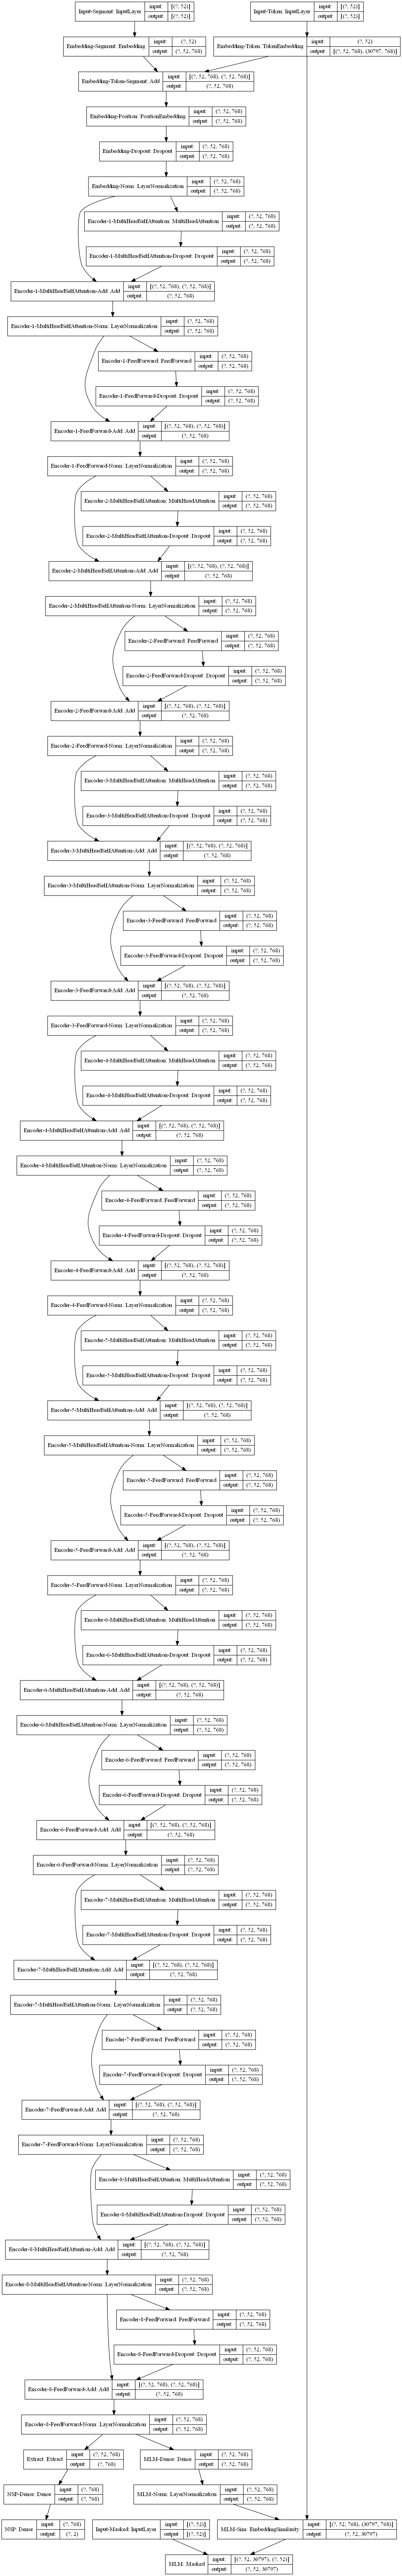

In [42]:
from IPython.display import SVG
import keras.utils 

tf.keras.utils.plot_model(model, show_shapes=True)


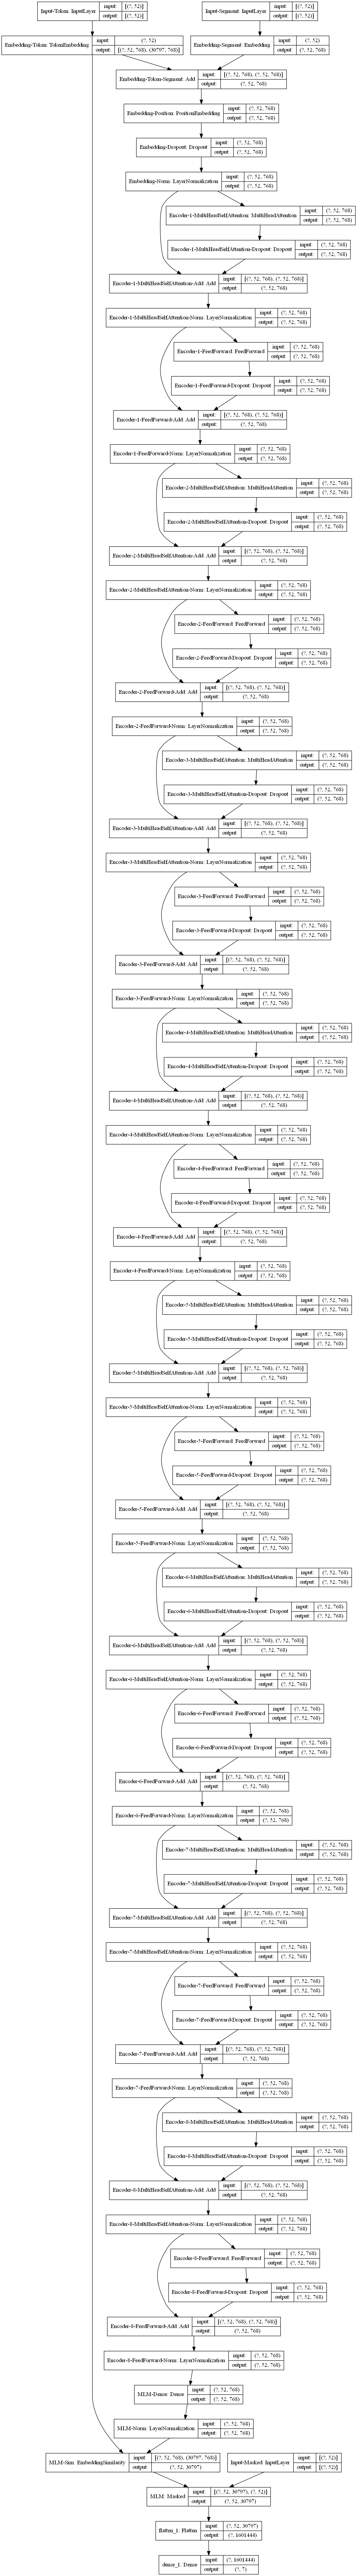

In [43]:
tf.keras.utils.plot_model(bert_model, show_shapes=True)

In [ ]:
history = bert_model.fit(x_train, y_train, epochs=2, batch_size=32,verbose = 1,validation_data=(x_test, y_test)  )

Epoch 1/2


C:\Users\smhrd\anaconda3\envs\keras1\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


 7719/11350 [===================>..........] - ETA: 19:21 - loss: 1.9516 - accuracy: 0.1437